In [204]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import pprint

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

from language_structure import *
from train import batch_iter, load
from model import *

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
testdf = pd.read_csv('test.csv')

In [4]:
model_path = '1108am-may25'
model, optim, lang, metrics = load(model_path, cpu=True)

In [206]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(metrics['args'])

{   '--batch-size': '128',
    '--clip-grad': '5.0',
    '--dropout': '0.1',
    '--embed-size': '1028',
    '--help': False,
    '--hidden-size': '256',
    '--load': False,
    '--load-from': 'default-model',
    '--log-every': '10',
    '--lr': '0.0003',
    '--max-epoch': '30',
    '--max-sent-len': '10000',
    '--n-heads': '2',
    '--n-layers': '2',
    '--n-valid': '2000',
    '--n-words': '2000',
    '--qtest': False,
    '--save': True,
    '--save-to': '1108am-may25',
    '--seed': '0',
    '--valid-niter': '40',
    '--validate-every': '40'}


In [70]:
def format_sent(sentence):
    formatted_sentence = ['<start>', '0']
    idxs = list(range(1, len(sentence)+1))
    for (w, i) in list(zip(sentence, idxs)):
        formatted_sentence.append(w)
        formatted_sentence.append(str(i))
    formatted_sentence.append('<end>')
    formatted_sentence.append(str(len(idxs)+1))
    
    return ' '.join(formatted_sentence)

Total Time: 431.5677 
Train Time: 92.513


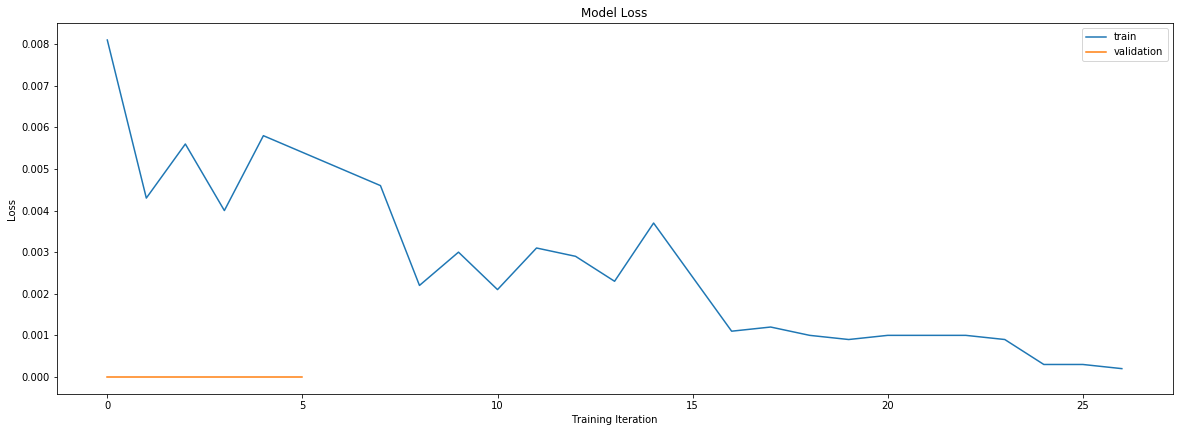

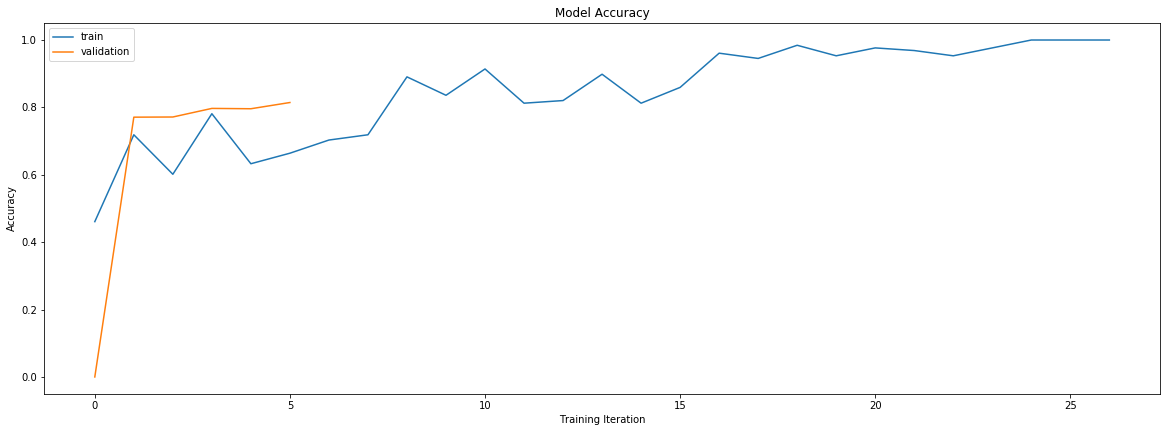

In [6]:
def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    figsize = (20, 15)
    plt.figure(1, figsize=figsize)                
    plt.subplot(211)
    plt.plot(metrics['itr'], metrics['train_loss'],  label='train')
    plt.plot(metrics['val_itr'], metrics['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    # plot accuracy
    plt.figure(2, figsize=figsize)                # a second figure
    plt.subplot(212)
    plt.plot(metrics['itr'], metrics['train_acc'], label='train')
    plt.plot(metrics['val_itr'], metrics['val_acc'], label='validation')
    plt.legend()
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    
    plt.show()
    
plot_metrics(metrics)

In [192]:
# Thanks to, 
# https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
batch_index = 0
sentence = x[batch_index]

def plot_sentence_attention(sentence, batch_idx=None, target='N/A', attention_layer=0):
    
    # Hook the Attention Weights
    attentions = model._modules.get('attentions')
    tracked_attention_weigths = []
    def show(m, i, o): 
        _, w = o
        tracked_attention_weigths.append(w)
    hook = attentions[attention_layer].register_forward_hook(show)
    
    # get attention weights
    x = [sentence] if batch_idx == None else sentence
    y = target if batch_idx == None else target[batch_idx]
    
    h_x = model(x)
    pred_y = h_x if batch_idx == None else h_x[batch_idx]
    pred_y = pred_y.detach().numpy().squeeze()
    
    print("Predicted Value: %.2f True Value: %.2f" % (pred_y, y))
    hook.remove()
    w = tracked_attention_weigths[0]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    attention = w.detach().numpy().squeeze()
    
    attention = attention if batch_idx == None else attention[batch_idx]
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}

    # ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    # ax.set_yticklabels([''] + sentence, fontdict=fontdict)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title("{}-Layer Long-Sentence Attention".format(attention_layer))
    plt.show()
    
    words = sentence if batch_idx == None else sentence[batch_idx]
    return format_sent(words)

# Sentences < 25 Length


In [141]:
# Sample Example from dataset
df = testdf[testdf.file_length < 25]
for sents, targets in batch_iter(lang, df, 3, shuffle=True):
    break

## Single Postive Example
### Attention Layer 0

Predicted Value: 0.97 True Value: 1.00


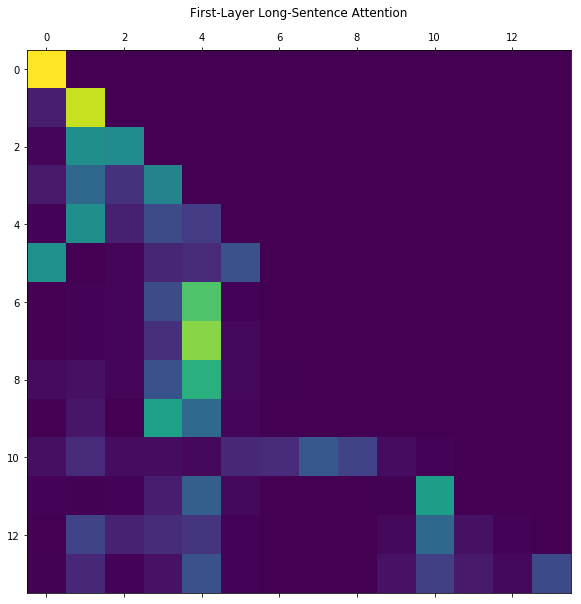

'<start> 0 as 1 a 2 big 3 fan 4 of 5 tiny 6 toon 7 adventures 8 i 9 loved 10 this 11 movie 12 <end> 13'

In [143]:
plot_sentence_attention(sents, batch_idx=0, target=targets)

### Attention Layer 1

Predicted Value: 0.97 True Value: 1.00


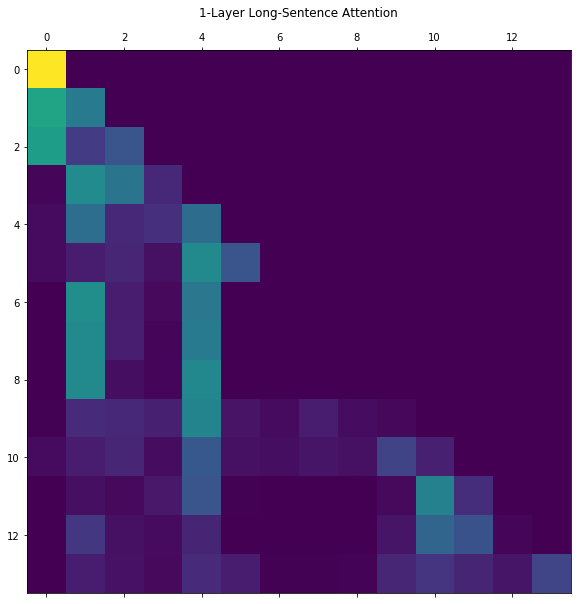

'<start> 0 as 1 a 2 big 3 fan 4 of 5 tiny 6 toon 7 adventures 8 i 9 loved 10 this 11 movie 12 <end> 13'

In [207]:
# no changes
sent = ['as','a','big', 'fan', 'of', 'tiny', 'toon', 'adventures', 'i', 'loved','this', 'movie']
plot_sentence_attention(sent, batch_idx=None, target=1.0, attention_layer=1)

## Negating The Sentence
### Change Word at Back
Changing 'loved' to 'hated' in the sentence.
Notice there is only a ~0.4% decrease in prediction, even though the verb is one of the most important. Still very small attention payed.

Predicted Value: 0.61 True Value: 0.00


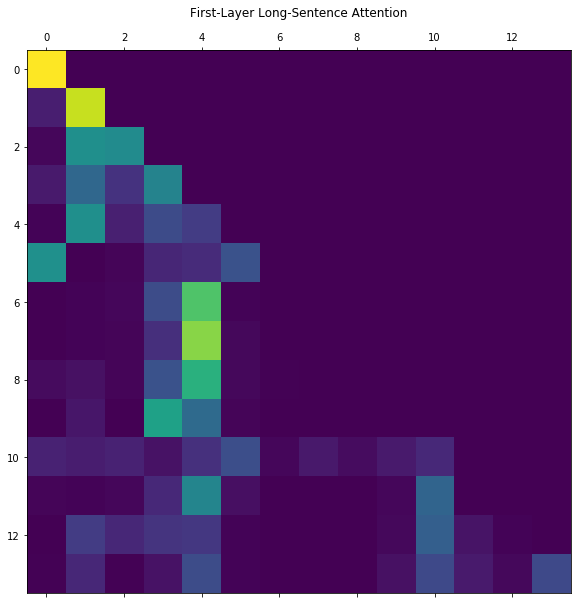

'<start> 0 as 1 a 2 big 3 fan 4 of 5 tiny 6 toon 7 adventures 8 i 9 hated 10 this 11 movie 12 <end> 13'

In [148]:
negated_sentence = ['as',
 'a',
 'big', 
 'fan',
 'of',
 'tiny',
 'toon',
 'adventures',
 'i',
 'hated',   # negated INDEX 10
 'this',
 'movie']
plot_sentence_attention(negated_sentence, batch_idx=None, target=0)

### Change Word at Front
Changing a word which is at the front of the sentence then changes the prediction accuracy back to ~1%. This shows that the self-attention is really only paying attention to the front. 

Predicted Value: 0.96 True Value: 0.00


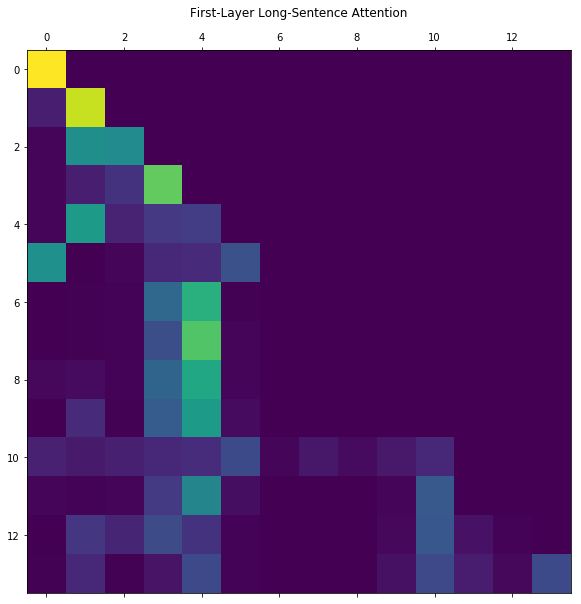

'<start> 0 as 1 a 2 small 3 fan 4 of 5 tiny 6 toon 7 adventures 8 i 9 hated 10 this 11 movie 12 <end> 13'

In [149]:
negated_sentence = ['as',
 'a',
 'small',     # negated
 'fan',
 'of',
 'tiny',
 'toon',
 'adventures',
 'i',
 'hated',   # negated
 'this',
 'movie']
plot_sentence_attention(negated_sentence, batch_idx=None, target=0)

# Sentences > 200 Length

In [157]:
# Sample Example from dataset
df = testdf[testdf.file_length > 200]
for sents, targets in batch_iter(lang, df, 3, shuffle=True):
    break

### Attention Layer 0

Predicted Value: 1.00 True Value: 1.00


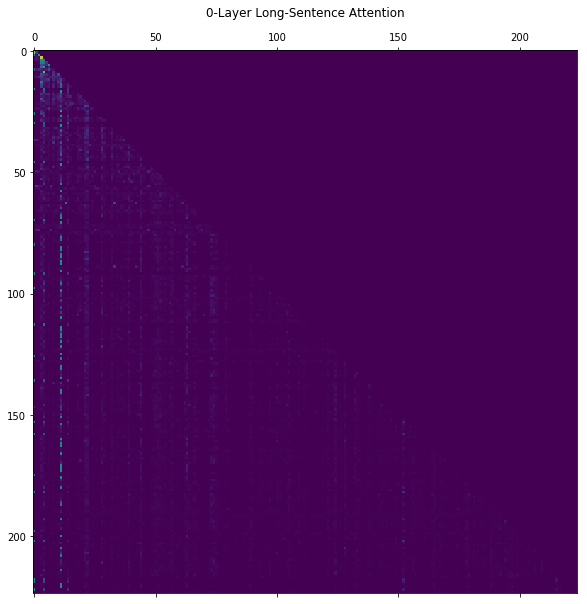

In [194]:
s = plot_sentence_attention(sents,
                        batch_idx=2,
                        target=targets,
                        attention_layer=0)

### Analysing Attention Payed
Notice the long-term points are not payed attention too at all even though they are just as important

In [203]:
print("     MAJOR ATTENTION:")
print(' '.join(sents[2][:25]))
print()
print("     NO ATTENTION:")
print(' '.join(sents[2][160:200]))

     MAJOR ATTENTION:
edith nesbitts best book has been adapted into a truly magnificent film i love it . the film itself has gorgeous cinematography and fine realisation

     NO ATTENTION:
and sally thomsett both gave spirited performances but it is jenny agutters enchanting portrayal of bobbie that impressed me the most . another special mention is the gorgeous music by johnny douglas the title music reminded me of charlie chaplins


### Attention Layer 1 

Predicted Value: 1.00 True Value: 1.00


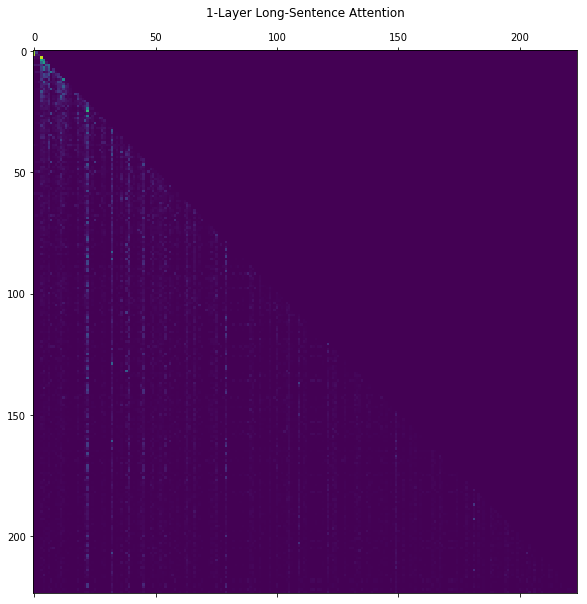

In [193]:
s = plot_sentence_attention(sents,
                        batch_idx=2,
                        target=targets,
                        attention_layer=1)